# Our MiniGrad From Scratch
special thanks to:
The ardej karpathy [click me](https://github.com/karpathy/micrograd)

## Importing Libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Creating a ploynomial function 

In [42]:
def f(x):
  return 3*x**2+2*x+1

In [43]:
f(3.0)

34.0

In [44]:
y = np.arange(-5,5,0.25)
value_y = f(y)

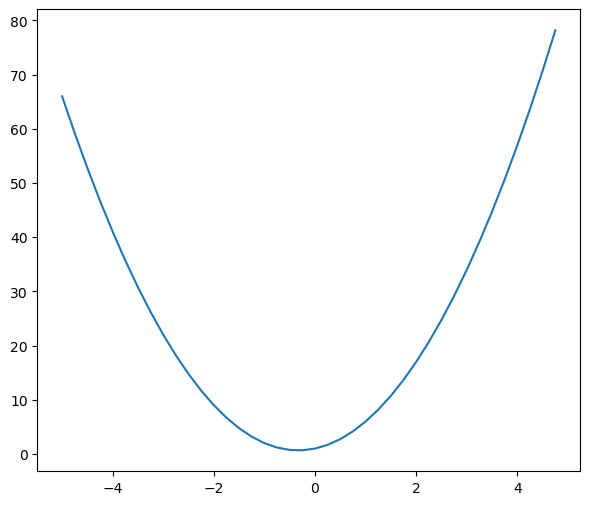

In [45]:
plt.figure(figsize=(7,6))
plt.plot(y,value_y);

## Understanding the Derivatives

**Now let's find the gradient of our funciton in a specific point(what's the slope of the funciton)** Using Calculus formula
[wikipedia on derviatives](https://en.wikipedia.org/wiki/Derivative)
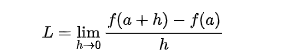

*the handwritten Calculus formula would be this according to the function`3*x**2+2*x+1` : 
`6x+2`* with respective X

In [46]:
h = 0.0000001
(f(3.0+h)-f(3.0))/h

20.000000304776222

**Here as we can see if we move our x value which is here 
`3.0` a slight amount of h = `0.000001`(which according to the formula it can go until zero)**

**How is our slope moves with respective to the little nudge on the x value and how much does it move with percentage**

## Let's Get intutive understanding of Neural Network Basic Formula

In [47]:
h = 0.01 #learning rate
#inputs 
x = 2.0
w = -4.0
b = 1

#function 
y_pred = x*w+b

y_pred

-7.0

In [48]:
h = 0.01
x = 2.0
w = -4.0
b = 1
x += h
after_nudge_y_pred = x*w+b
print("the normal function output is:->",y_pred)
print("after the nudge with learning rate is:->",after_nudge_y_pred)
print("the slope or rate of change with respective to the nudge is:->",(after_nudge_y_pred-y_pred)/h)

the normal function output is:-> -7.0
after the nudge with learning rate is:-> -7.039999999999999
the slope or rate of change with respective to the nudge is:-> -3.9999999999999147


## Now let's create a Data Structure where all our neccessary info is available in one object

In [289]:
class Value:
    def __init__(self,data,_children=(),op='',label=''):
        self._prev = set(_children)
        self.data = data
        self._op = op
        self._backward= lambda:None
        self.grad = 0.0
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        v = Value(self.data+other.data,
                  _children = (self,other),
                  op='+')
        def _backward():
            self.grad +=1.0*v.grad #local Grad
            other.grad +=1.0*v.grad #global Grad
        v._backward = _backward
        return v
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        v = Value(self.data * other.data,
                  _children=(self,other),
                  op='*')
        def _backward():
            self.grad += other.data * v.grad
            other.grad += self.data * v.grad
        v._backward = _backward
        return v
    
    
    def exp(self):
        x = self.data
        e = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += e.data * e.grad
        e._backward = _backward
        return e

    
    def __pow__(self,other):
        assert isinstance(other,(int,float)) ,"only supporting int/float powers for now"
        out = Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad += (other*self.data**(other-1))*out.grad
        out._backward = _backward
                          
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),"tanh")
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
            
            
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self,other):
        return self + (-other)
    
    def __truediv__(self,other):#equals to 
        return self*other**-1

    def __rmul__(self,other):#if python can't do int*our_class then it will run
        return self*other

    def __repr__(self):
        return f"Value(Data={self.data})"

In [50]:
m = Value(1,label="m")
n = Value(2,label="n")
t = m+n
t.label = "t"
t.grad=1.0
t._backward()

In [51]:
t._prev

{Value(Data=1), Value(Data=2)}

### his visualization for forward propagation and backward propagation 

In [52]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Manual backpropagation

The question we need to ask his:
    
    If I Change the `L` in a tiny amount of `H` how much does the `L` change *I know this example doesn't make any sense you get the idea 
    It's changes by `H` it's proportional so the derivative for L will be 1 respective L
    
    Let's see it in action

In [56]:
h = 0.001
#not nudging
x = Value(3.0,label="x")
b = Value(1.0,label="y")
c = x+b;c.label = 'c'
d = Value(8.0,label="d")
L = c * d
L.label = "L"
L1 = L

#nudging
x = Value(3.0 ,label="x")
b = Value(1.0,label="y")
c = x+b
c.label = 'c'
d = Value(8.0,label="d")
L = c * d
L.label = "L"
L2 = L.data+h

In [53]:
def lol():
    h = 0.001
    #not nudging
    x = Value(3.0,label="x")
    b = Value(1.0,label="y")
    c = x+b;c.label = 'c'
    d = Value(8.0,label="d")
    L = c * d
    L.label = "L"
    L1 = L
    
    #nudging
    x = Value(3.0 ,label="x")
    b = Value(1.0,label="y")
    c = x+b
    c.label = 'c'
    d = Value(8.0,label="d")
    L = c * d
    L.label = "L"
    L2 = L.data+h
    
    print("the first loss is :",L1)
    print("After The nudge of h in respective value:",L2)
    print("The Derivative of L with respective Increase Value:",(L1.data-L2)/h)

In [54]:
lol()

the first loss is : Value(Data=32.0)
After The nudge of h in respective value: 32.001
The Derivative of L with respective Increase Value: -0.9999999999976694


`now if i manually set L2.grad = 1 we created manual Backpropagation atleast started it with manual method`

## Now let's find out what if we change our d value how much would that affect our L2 

To find: 
    
    `dl/dd` - chaging the d how much does it affect l
    
    we aldready know `l = c * d`
    
    if we derive this using formula 
    
    `(f(x+h)-f(x))/h`
    
    here f(x) = c*d
    
    Now -> (c*(d+h)-(c*d))/h
            
        -> c*d + c*h - c*d /h
           
        -> c*h/h
            
        -> c
       
    dl/dd -> c
    

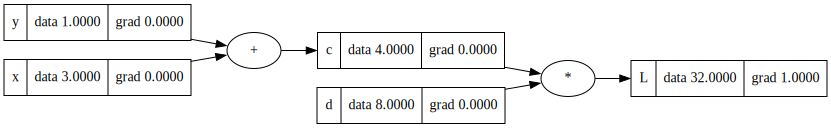

In [57]:
L.grad = 1
draw_dot(L)

So now accourding to the formula `d.grad` is just `4` which is our `C value`

And Vice versa

In [58]:
d.grad = 4
c.grad = 8

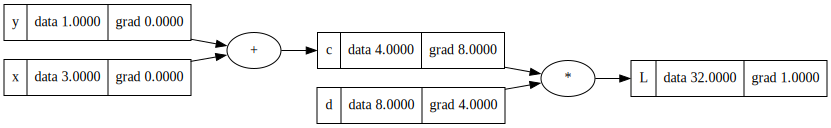

In [59]:
draw_dot(L)

### now let's check why not ?

In [60]:
def lol():
    h = 0.001
    #not nudging
    x = Value(3.0,label="x")
    b = Value(1.0,label="y")
    c = x+b;c.label = 'c'
    d = Value(8.0,label="d")
    L = c * d
    L.label = "L"
    L1 = L
    
    #nudging
    x = Value(3.0 ,label="x")
    b = Value(1.0,label="y")
    c = x+b
    c.label = 'c'
    d = Value(8.0+h,label="d")
    L = c * d
    L.label = "L"
    L2 = L.data
    
    print("the first loss is :",L1)
    print("After The nudge of h in respective value:",L2)
    print("The Derivative of L with respective Increase Value in D:",(L2-L1.data)/h)

In [61]:
lol()

the first loss is : Value(Data=32.0)
After The nudge of h in respective value: 32.004
The Derivative of L with respective Increase Value in D: 3.999999999997783


**it's same hurray !!!! 🥳🥳🥳**

## So now The Important of BackPropagation

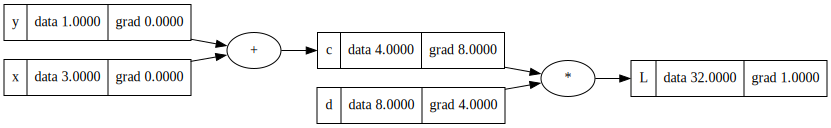

In [62]:
draw_dot(L)

We now know how `L` is sensitive to `C` and `D` ->("$dl/dc$","$dl/dd$")

but how much is `L` sensitive to `y` and `x` ->("$dl/dy$","$dl/dx$")

**Local Derivaties(which doesn't know what happening in the outermost layer of our function it's not connected yet)**

Let's break down the equation to manageable part 

Let's find the Local Derivative which is respective "$dl/dy , dl/dx$"

-> "$dc/dy$" =>1.0

-> here we know c = x + y 

-> let's find the derivative for dc/dy which is 1

-> f(x+h)-f(x)/h

-> (x+ y+h -(x+y))/h

-> (x+ y+h -x-y)/h

-> h/h

-> 1

Similarly :

-> "$dc/dx$" = 1.0

**Now global Derivative**

-> We want "$dl/dx$" By chain rule which tells us we want to find "$dl/dc * dc/dx$"
    
-> We Know "$dl/dc$" which is `8` "$dc/dx$" which is `1.0`



In [63]:
##Now
b.grad = 8
x.grad = 8

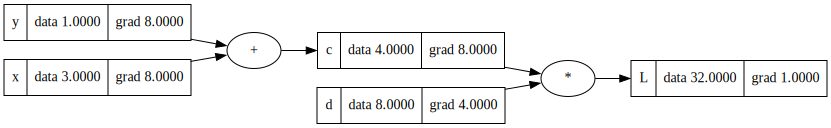

In [64]:
draw_dot(L)#ignore the x and y in front that's just a syntax error

In [65]:
#let's check 
def lol():
    h = 0.001
    #not nudging
    x = Value(3.0,label="x")
    b = Value(1.0,label="y")
    c = x+b;c.label = 'c'
    d = Value(8.0,label="d")
    L = c * d
    L.label = "L"
    L1 = L
    
    #nudging
    x = Value(3.0+h,label="x")
    b = Value(1.0,label="y")
    c = x+b
    c.label = 'c'
    d = Value(8.0,label="d")
    L = c * d
    L.label = "L"
    L2 = L.data
    
    print("the first loss is :",L1)
    print("After The nudge of h in respective value:",L2)
    print("The Derivative of L with respective Increase Value in D:",(L2-L1.data)/h)

In [66]:
lol()

the first loss is : Value(Data=32.0)
After The nudge of h in respective value: 32.007999999999996
The Derivative of L with respective Increase Value in D: 7.999999999995566


**Again hurray!!!🥳🥳**

## neural Network

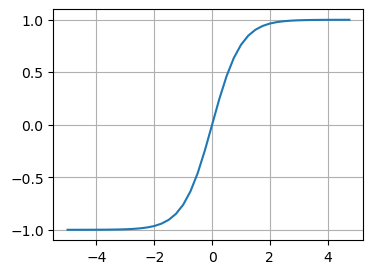

In [67]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(-5.0,5,0.25),np.tanh(np.arange(-5.0,5.0,0.25)))
plt.grid()

In [68]:
#inputs 
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

#weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

#bias 
b = Value(6.8813735870195432,label="b")

#calculation
x1w1 = x1*w1
x1w1.label="x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label="x1w1+x2w2"

#adding bias
n = x1w1x2w2+b;n.label="n"

o = n.tanh();o.label="o"

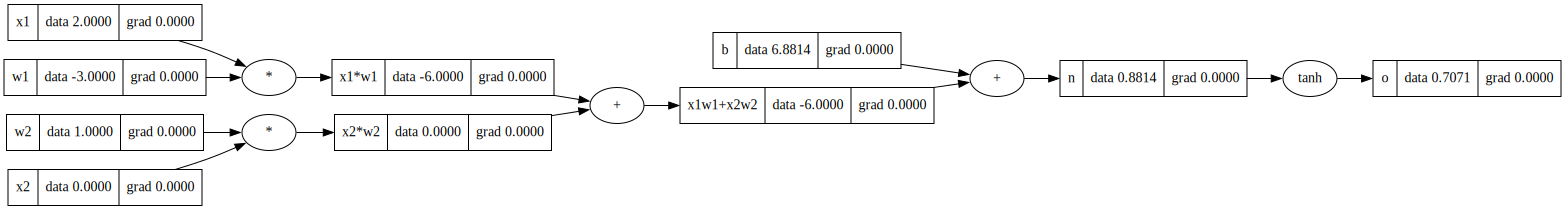

In [69]:
draw_dot(o)

### Let's fill the gradient out shall wee in manual Way

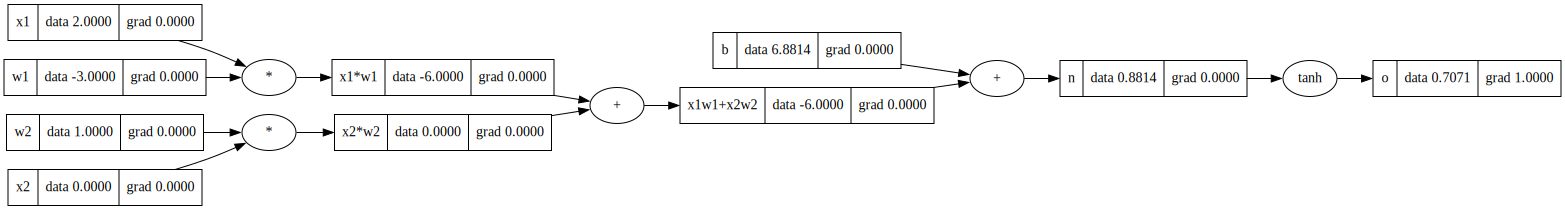

In [70]:
o.grad = 1.0#default if i change the o value the o value is going to be affected by 1 percentage
draw_dot(o)

but now we need to find the derivative of tanh function to calculate the gradient of n
 
 o = tanh(n)
 
 do/dn = "$1-tanh(n)^2$" (took from wikipedia you don't have to do this by hand hahaha)
 
 we aldready know tanh(n)-> output data of loss or here o
 
 so now it's "$1-o^2$"
 
 and o = output of the tanh function which is 0.7071
 
 

In [71]:
1-o.data**2

0.4999999999999999

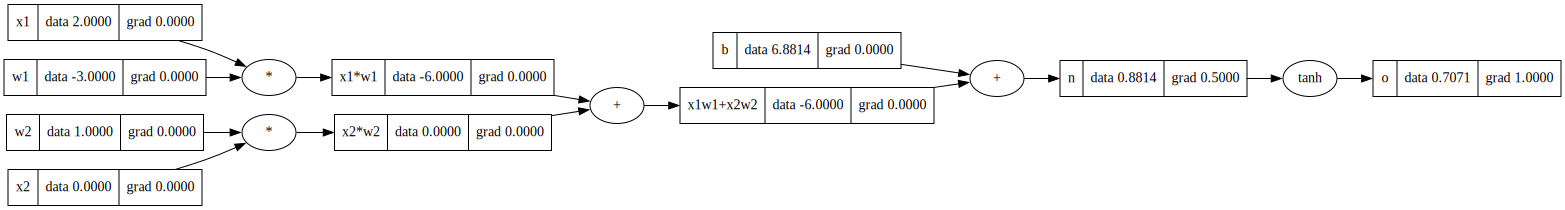

In [72]:
#the local derivative of do/dn is 0.5 which is the above output
n.grad=0.5
draw_dot(o)

In [73]:
#next just a plus symbol which we know it's just going to be one 
b.grad = 0.5
x1w1x2w2.grad = 0.5

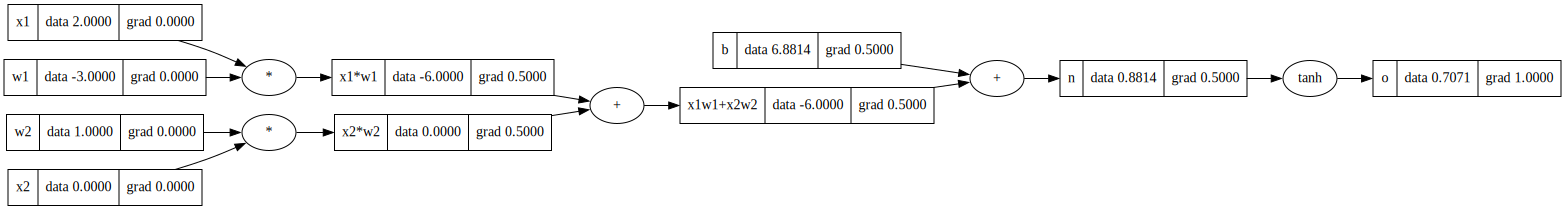

In [74]:
#again same
x2w2.grad = 0.5
x1w1.grad=0.5
draw_dot(o)

now the x gradient is "$do/dx1$"->
"$do/dn*dn/dx1w1x2w2*dx1w1x2w2/dx1w1*dx1w1/dx1$"

In [75]:
#we aldread know dx1w1x2w2/dx1w1
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

In [76]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

## In automatic way

In [77]:
#inputs 
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

#weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

#bias 
b = Value(6.8813735870195432,label="b")

#calculation
x1w1 = x1*w1
x1w1.label="x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label="x1w1+x2w2"

#adding bias
n = x1w1x2w2+b;n.label="n"

o = n.tanh();o.label="o"

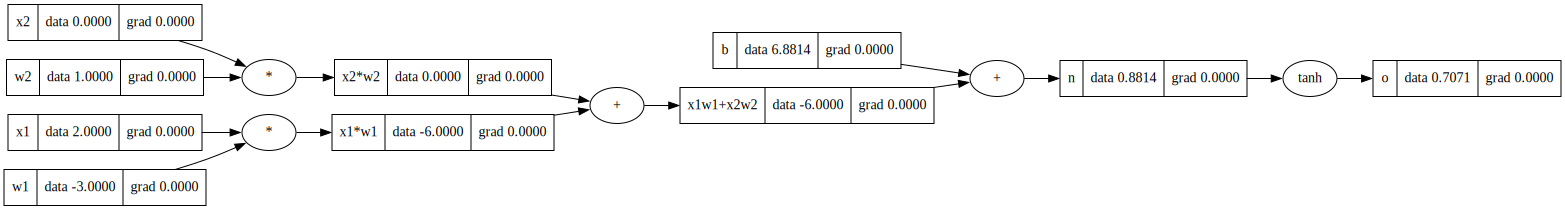

In [78]:
draw_dot(o)

o.backward => n.tanh()

"$1-tanh(n)^2$"

"$1-0.7071^2$"

the backpropagation formula goes like this considering chain rule

"$0.44444*o.grad$"

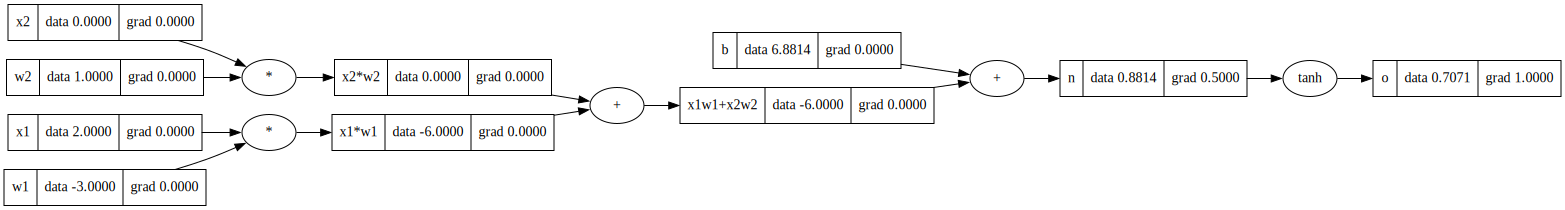

In [79]:
o.grad = 1.0#why because in our function we multiply the self.grad with 1.tanh**2 which at start going to have 0
o._backward()#we got derivative for n 
draw_dot(o)

Because the derivative of + simble is going to be 1 anyway

the formula goes like this

"$1*prevgrad$"

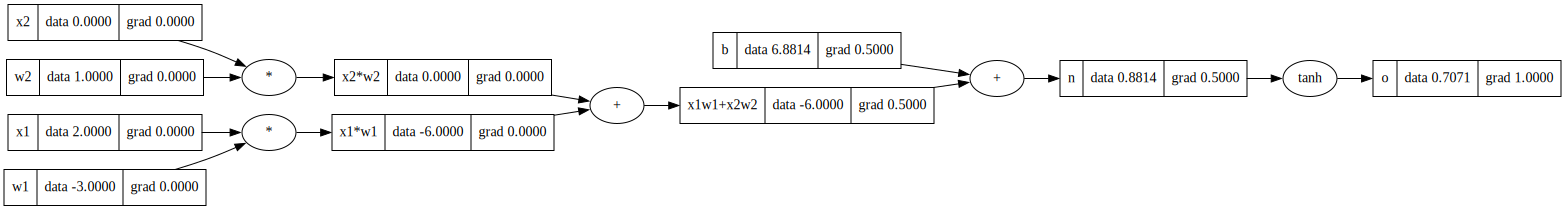

In [80]:
n._backward()
draw_dot(o)

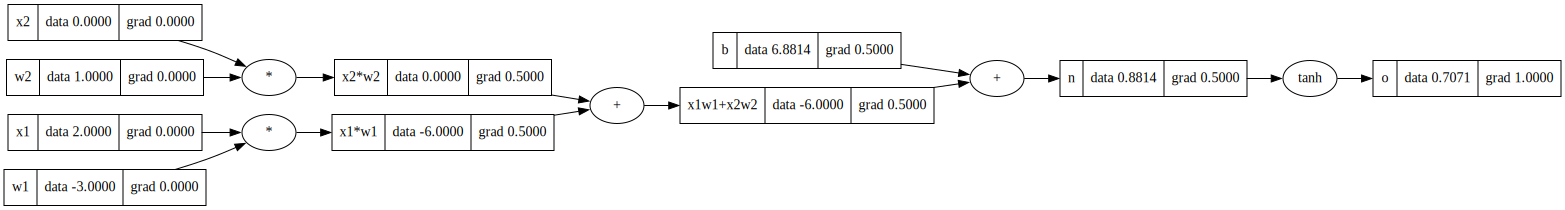

In [81]:
x1w1x2w2._backward()
draw_dot(o)

The dervative of x1*w1 is x1*w1 = x1 * w1

Because we know any multiplicative term derivative just other number 

eg-> from x1 point of view my value can change w1 times and vice versa

the formula goes like this 

"for x1.grad = $w1.data*prevgrad$" and same goes to w1

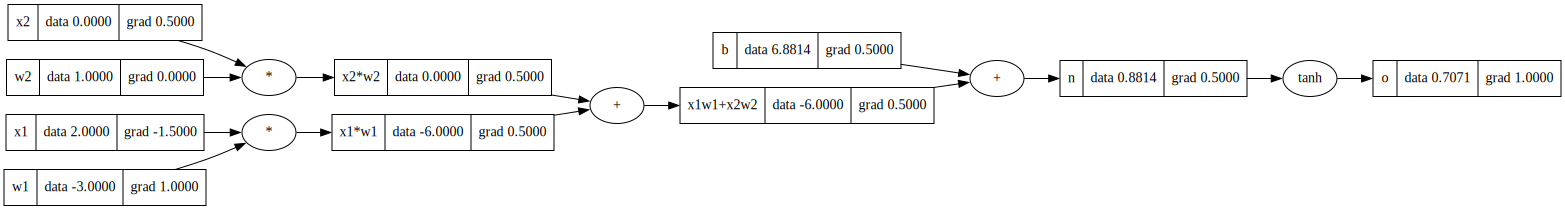

In [82]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

### another way of doing it

Example:

Let's say we have a simple graph that consists of 3 vertexes, A, B, C and B is the child of A and C is the child of B.

topo = []: topo is an empty list

visited = set(): visited is an empty set

build_topo(A):

if A not in visited:: A is not visited yet so the next lines of code will be executed

visited.add(A): A is added to the visited set

for child in A._prev:: A has one child B


build_topo(B):

if B not in visited:: B is not visited yet so the next lines of code will be executed

visited.add(B): B is added to the visited set

for child in B._prev:: B has one child C

build_topo(C):

if C not in visited:: C is not visited yet so the next lines of code will be executed

visited.add(C): C is added to the visited set

for child in C._prev:: C has no child so the loop end

topo.append(C): C is added to the topo list

topo.append(B): B is added to the topo list

topo.append(A): A is added to the topo list


In [83]:
o.backward()

## Let's make tanh function even depth

### Exception case solving before that

In [84]:
a = Value(2.0)
a + 1

Value(Data=3.0)

In [85]:
b = Value(2.0)
b*2

Value(Data=4.0)

In [86]:
2*b

Value(Data=4.0)

In [87]:
b.exp()


Value(Data=7.38905609893065)

In [88]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(Data=0.5)

In [89]:
a-b

Value(Data=-2.0)

## Back to the problem

In [90]:
#inputs 
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

#weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

#bias 
b = Value(6.8813735870195432,label="b")

#calculation
x1w1 = x1*w1
x1w1.label="x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label="x1w1+x2w2"

#adding bias
n = x1w1x2w2+b;n.label="n"

o = n.tanh();
o.label="o"

In [91]:
o.backward()

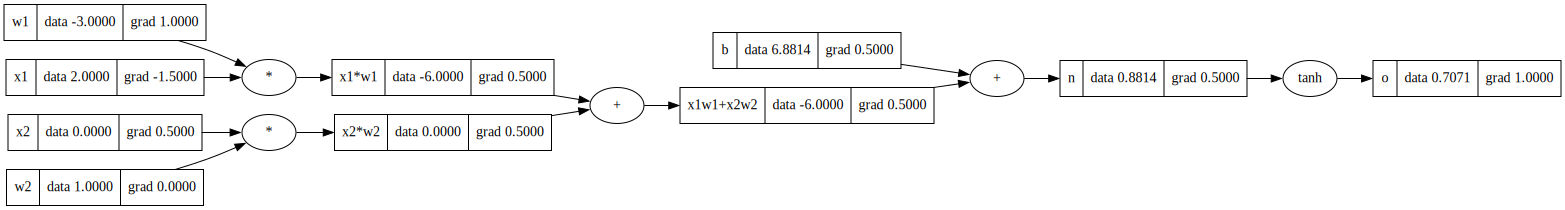

In [92]:
draw_dot(o)

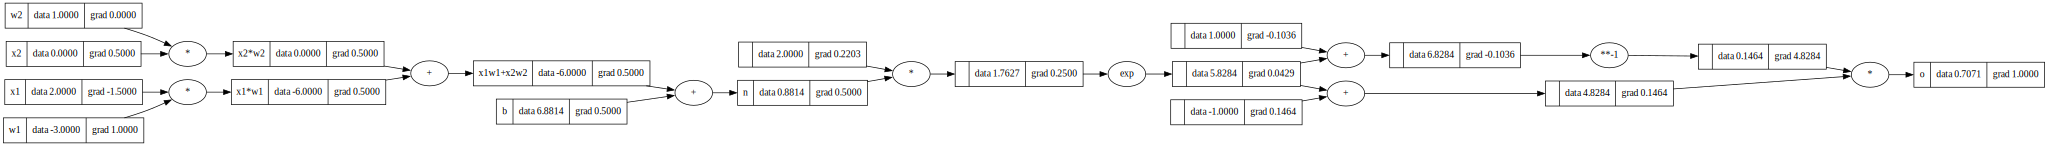

In [93]:
#inputs 
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

#weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

#bias 
b = Value(6.8813735870195432,label="b")

#calculation
x1w1 = x1*w1
x1w1.label="x1*w1"

x2w2 = x2*w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label="x1w1+x2w2"

#adding bias
n = x1w1x2w2+b;n.label="n"
#--#custom tanh
e = (2*n).exp()
o = (e-1)/(e+1)
#-----
o.label="o"
o.backward()
draw_dot(o)

## Now doing with Libraries

In [94]:
import torch
o = torch.Tensor([2.0]).double()
o,o.data,o.data.item()

(tensor([2.], dtype=torch.float64), tensor([2.], dtype=torch.float64), 2.0)

In [95]:
x1 = torch.Tensor([2.0]).double();x1.requires_grad=True
x2 = torch.Tensor([0.0]).double();x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double();w1.requires_grad=True
w2 = torch.Tensor([1.0]).double();w2.requires_grad=True

b = torch.Tensor([6.8813735870195432]).double();b.requires_grad=True

n = w1*x1+w2*x2+b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("-------")
print("x1",x1.grad.item())
print("x2",x2.grad.item())
print("w1",w1.grad.item())
print("w2",w2.grad.item())

0.7071066904050358
-------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


## Building Neural Net 

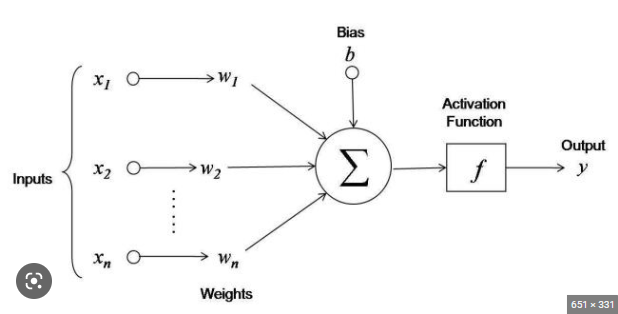

In [98]:
import random

In [321]:
class Neuron:
    def __init__(self,n_dimention):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(n_dimention)]
        self.bais = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        activation = sum((wi*xi for wi,xi in zip(self.weights,x)),self.bais)
        out = activation.tanh()
        return out
    def parameters(self):
        return self.weights + [self.bais]

In [322]:
x = [1,2,3]
N = Neuron(3)
output = N(x)
output

Value(Data=0.9953706774963578)

In [323]:
# draw_dot(output)

we just build the one neuron with python let's go and build the hidden layer 

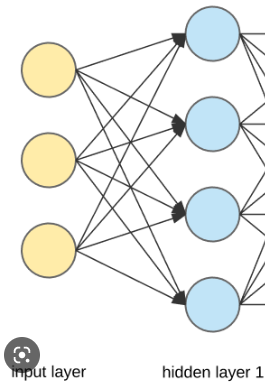

In [324]:
class Layer:
    def __init__(self,n_dim,n_out):
        self.neurons = [Neuron(n_dim)for _ in range(n_out)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]

In [325]:
L = Layer(3,4)
output = L(x)
output

[Value(Data=0.9749511338238096),
 Value(Data=0.9569432556868498),
 Value(Data=0.9988404582240762),
 Value(Data=-0.9944582843665666)]

In [326]:
# draw_dot(output) don't run this because it contains list of elements

Now Full MLP (Multi Layer Preceptron)

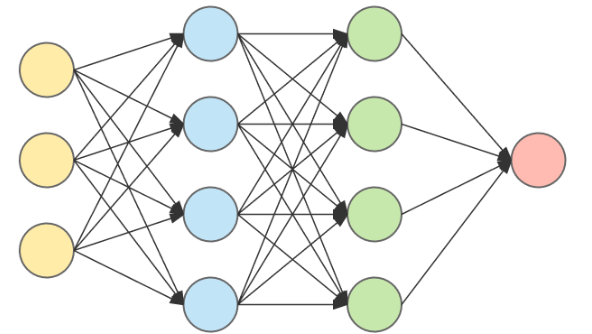

In [327]:
class MLP:
    def __init__(self,n_dim,n_hidden):
        list_of_size = [n_dim]+n_hidden
        self.layers = [Layer(list_of_size[i],list_of_size[i+1])for i in range(len(n_hidden))]
    def __call__(self,x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for layers in self.layers for p in layers.parameters()]

In [328]:
M = MLP(3,[4,4,1])
output = M(x)
output

Value(Data=0.8303690397592592)

In [329]:
# draw_dot(output)

## Tiny Dataset and Loss Function

In [330]:
xs = [
    [2.0,3.2,4.5],
    [3.0,5.5,6.3],
    [0.5,3.2,1.1],
    [6.0,6.7,9.2],
]

ys = [1.0,-1.0,-1.0,1.0]

In [331]:
ypred = [M(x) for x in xs]
ypred

[Value(Data=0.8616254662837165),
 Value(Data=0.8175686989183008),
 Value(Data=0.7794007756188203),
 Value(Data=0.8759673391666768)]

In [332]:
loss = sum((pred-y)**2 for pred,y in zip(ypred,ys))
loss

Value(Data=6.504354708095017)

In [344]:
# draw_dot(loss)

In [334]:
loss.backward()

In [343]:
# draw_dot(loss)

In [336]:
M.layers[0].neurons[0].weights[0],M.layers[0].neurons[0].weights[0].grad

(Value(Data=0.5339969426775966), 0.03895107587173319)

The Gradient is telling us....If we slightly increase this particular weight the loss will go down 

In [338]:
len(M.parameters())#in total this mlp has 41 parameters

41

## optimizing the parameters

In [340]:
M.parameters()[0].data

0.5339969426775966

In [341]:
for p in M.parameters():
    p.data -= 0.01*p.grad

In [342]:
M.layers[0].neurons[0].weights[0]

Value(Data=0.5336074319188793)

In [345]:
ypred = [M(x) for x in xs]
loss = sum((pred-y)**2 for pred,y in zip(ypred,ys))
loss

Value(Data=6.059031729060727)

## Gradient Descent

In [353]:
for k in range(20):
    #forward pass 
    ypred = [M(x)for x in xs]
    loss = sum((pred-y)**2 for pred,y in zip(ypred,ys))
    
    #backward pass
    for p in M.parameters():
        p.grad = 0.0
    loss.backward()
    
    #updating
    for p in M.parameters():
        p.data -= 0.01*p.grad
    loss = sum((pred-y)**2 for pred,y in zip(ypred,ys))
    print(f"epochs:{k} || Loss :{loss}")


epochs:0 || Loss :Value(Data=0.12801112078513202)
epochs:1 || Loss :Value(Data=0.12521898693705732)
epochs:2 || Loss :Value(Data=0.12252785984521244)
epochs:3 || Loss :Value(Data=0.11993264519527953)
epochs:4 || Loss :Value(Data=0.11742859073723147)
epochs:5 || Loss :Value(Data=0.11501125536154805)
epochs:6 || Loss :Value(Data=0.11267648200224586)
epochs:7 || Loss :Value(Data=0.11042037374025501)
epochs:8 || Loss :Value(Data=0.1082392726062085)
epochs:9 || Loss :Value(Data=0.10612974067857418)
epochs:10 || Loss :Value(Data=0.10408854314839329)
epochs:11 || Loss :Value(Data=0.10211263308094544)
epochs:12 || Loss :Value(Data=0.10019913765130103)
epochs:13 || Loss :Value(Data=0.09834534566785089)
epochs:14 || Loss :Value(Data=0.0965486962276842)
epochs:15 || Loss :Value(Data=0.09480676837175547)
epochs:16 || Loss :Value(Data=0.09311727162736437)
epochs:17 || Loss :Value(Data=0.09147803734154052)
epochs:18 || Loss :Value(Data=0.0898870107222048)
epochs:19 || Loss :Value(Data=0.088342243514

In [354]:
ypred#predicted value

[Value(Data=0.8003722839619027),
 Value(Data=-0.7975086068857471),
 Value(Data=-0.9236792362479463),
 Value(Data=0.9592152572725389)]

In [356]:
ys#true value

[1.0, -1.0, -1.0, 1.0]

# Finally Finished MiniGrad 🥳🥳🤠🤡 `Again LOVE YOU ANDREJ KARPATHY`